In [1]:
from dataloader import GraphTextDataset, GraphDataset, TextDataset
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.loader import DataLoader

from transformers import AutoTokenizer
import torch
from torch import optim
import time
import os
import pandas as pd
from Model import Model

from f_during_train import  dict_params, possible_model_names
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

/Users/Hippolyte/anaconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset tests

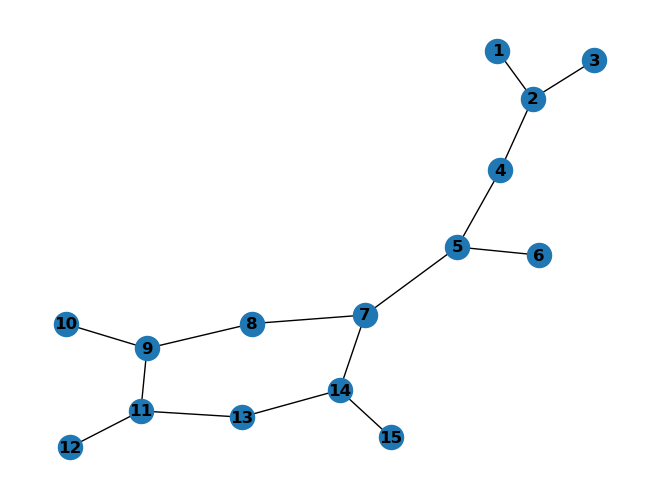

In [2]:
data = torch.load('data/processed/train/data_16230.pt') 

edges = data['edge_index'].numpy().T

G = nx.Graph()
G.add_edges_from(edges)

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [3]:
def analyze_graph(G):
    nodes = G.number_of_nodes()
    edges = G.number_of_edges()
    degrees = [d for n, d in G.degree()]
    degree_moyen = sum(degrees) / len(degrees)
    return({'nodes' :nodes , 'edges': edges, 'degree_moyen': degree_moyen})

def plot_graph(G):
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Visualisation du graphe")
    plt.show()

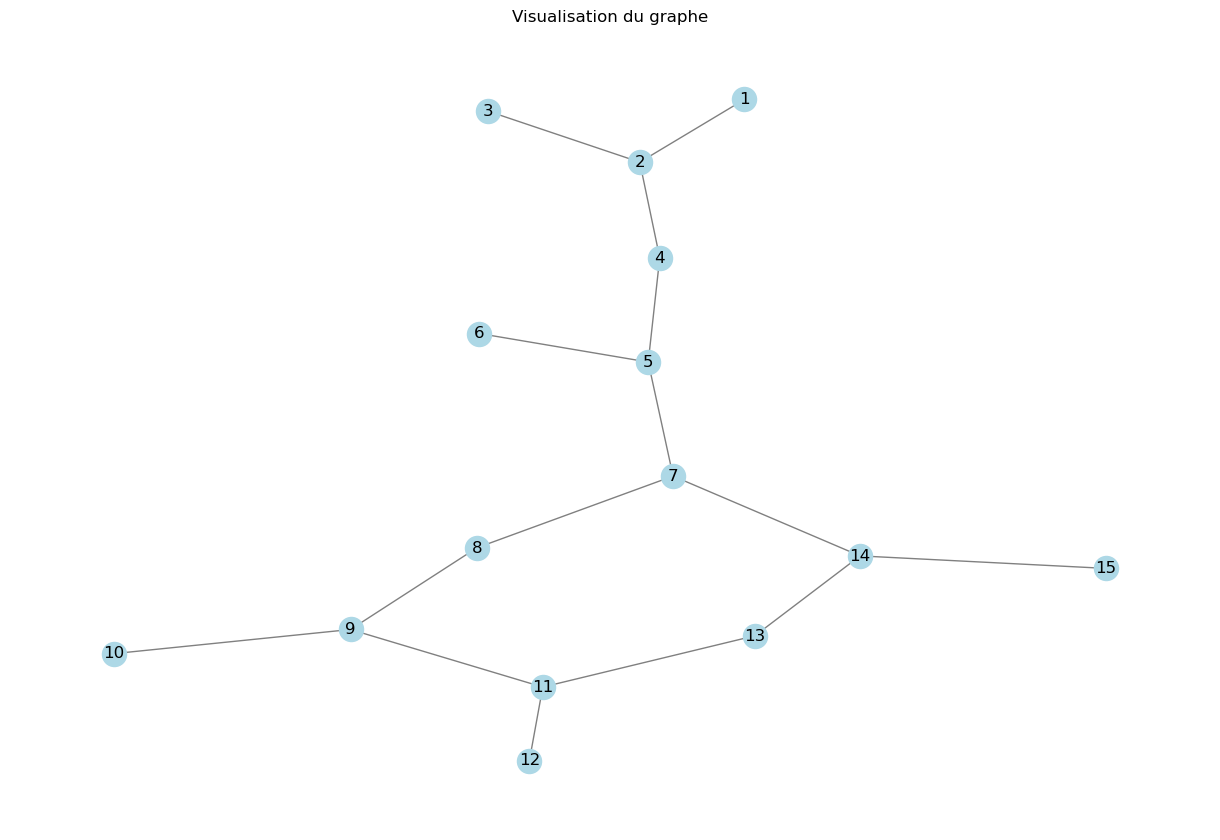

In [4]:
analyze_graph(G)
plot_graph(G)

In [5]:
dico = {}
for index in range(150000000): 
    try : 
        data = torch.load(f'data/processed/train/data_{index}.pt')

        edges = data['edge_index'].numpy().T
        G = nx.Graph()
        G.add_edges_from(edges)

        dico[f'graph_{index}'] = analyze_graph(G)  
    except: 
        continue  
nodes_values = [graph['nodes'] for graph in dico.values()]
edges_values = [graph['edges'] for graph in dico.values()]
degrees_values = [graph['degree_moyen'] for graph in dico.values()]

average_nodes = sum(nodes_values) / len(nodes_values)
max_nodes = max(nodes_values)
min_nodes = min(nodes_values)

average_edges = sum(edges_values) / len(edges_values)
max_edges = max(edges_values)
min_edges = min(edges_values)

average_degrees = sum(degrees_values) / len(degrees_values)
max_degrees = max(degrees_values)
min_degrees = min(degrees_values)

print('average_nodes :', average_nodes, '\nmax_nodes :' ,max_nodes,'\nmin_nodes :',
      min_nodes, '\naverage_edges :', average_edges,'\nmax_edges', max_edges, '\nmin_edges :', 
      min_edges , '\naverage_degrees :', average_degrees,'\nmax_degrees :', max_degrees, '\nmin_degrees :', min_degrees)


## Model tests

In [10]:

Model_PATH = '/Users/Hippolyte/Desktop/MVA/P1/NLP/Altegrad-Kaggle-Project/weights/ChebConv_modelname_1_drop_False_temp_0.5_lr3e-05_losstype_basic_alpha_0_wd0.01_initbs32_finalbs220_nout_200_model85.pt'



init_batch_size = 32
final_batch_size = 220


model_name = possible_model_names[1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
gt = np.load("./data/token_embedding_dict.npy", allow_pickle=True)[()]
val_dataset = GraphTextDataset(root='./data/', gt=gt, split='val', tokenizer=tokenizer)
train_dataset = GraphTextDataset(root='./data/', gt=gt, split='train', tokenizer=tokenizer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


batch_size =   init_batch_size
learning_rate = 3e-5

val_loader = DataLoader(val_dataset, batch_size=init_batch_size, shuffle=True)

dict_params['drop'] = False
dict_params['conv_layer'] = 'ChebConv'
dict_params['nout'] = 200
dict_params['model_name'] = model_name
model = Model(**dict_params) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

print('loading best model...')
checkpoint = torch.load(Model_PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

loading best model...


Model(
  (graph_encoder): GraphEncoder(
    (relu): ReLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (conv3): GCNConv(300, 300)
    (conv4): GCNConv(300, 300)
    (conv1): GATv2Conv(300, 300, heads=1)
    (conv2): GCNConv(300, 300)
    (mol_hidden1): Linear(in_features=300, out_features=300, bias=True)
    (mol_hidden2): Linear(in_features=300, out_features=768, bias=True)
  )
  (text_encoder): TextEncoder(
    (bert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
    

In [8]:
checkpoint['validation_accuracy']


17.74989294912666

## Create CSV file

In [ ]:
name_exp = 'exp1'

In [33]:
graph_model = model.get_graph_encoder()
text_model = model.get_text_encoder()

test_cids_dataset = GraphDataset(root='./data/', gt=gt, split='test_cids')
test_text_dataset = TextDataset(file_path='./data/test_text.txt', tokenizer=tokenizer)

idx_to_cid = test_cids_dataset.get_idx_to_cid()

test_loader = DataLoader(test_cids_dataset, batch_size=init_batch_size, shuffle=False)

graph_embeddings = []
for batch in test_loader:
    for output in graph_model(batch.to(device)):
        graph_embeddings.append(output.tolist())

test_text_loader = TorchDataLoader(test_text_dataset, batch_size=init_batch_size, shuffle=False)
text_embeddings = []
for batch in test_text_loader:
    for output in text_model(batch['input_ids'].to(device), 
                            attention_mask=batch['attention_mask'].to(device)):
        text_embeddings.append(output.tolist())


from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(text_embeddings, graph_embeddings)

solution = pd.DataFrame(similarity)
solution['ID'] = solution.index
solution = solution[['ID'] + [col for col in solution.columns if col!='ID']]
solution.to_csv(name_exp+'_submission.csv', index=False)

AttributeError: 'list' object has no attribute 'to'